# Programming Project #1: Hybrid Images

## CS445: Computational Photography

### Part I: Hybrid Images

In [4]:
import cv2
import numpy as np
from matplotlib.colors import LogNorm

from scipy import signal
import utils
import matplotlib.pyplot as plt
from ipywidgets import interact

datadir = './'

In [5]:
%matplotlib widget
import matplotlib.pyplot as plt

In [6]:
im1_file = datadir + 'nutmeg.jpg'
im2_file = datadir + 'DerekPicture.jpg'

im1 = np.float32(cv2.imread(im1_file, cv2.IMREAD_GRAYSCALE) / 255.0)
im2 = np.float32(cv2.imread(im2_file, cv2.IMREAD_GRAYSCALE) / 255.0)

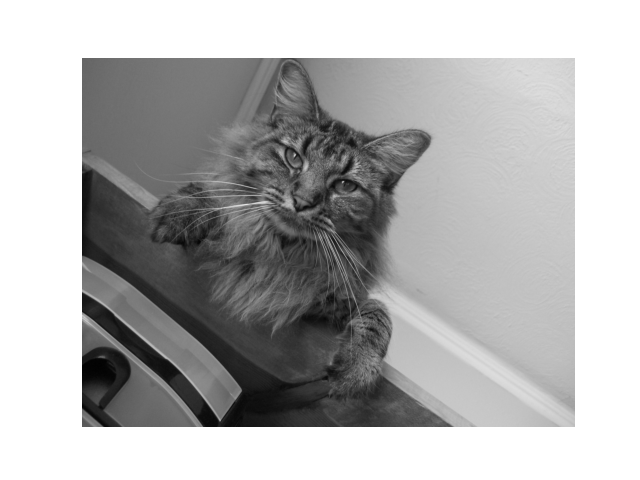

In [7]:
pts_im1 = utils.prompt_eye_selection(im1)
# pts_im1 = np.array([[607, 290], [748, 370]]) # uncomment if entering [x, y] pts manually
# plt.plot(pts_im1[:,0], pts_im1[:,1], 'r-+')
# print(pts_im1)

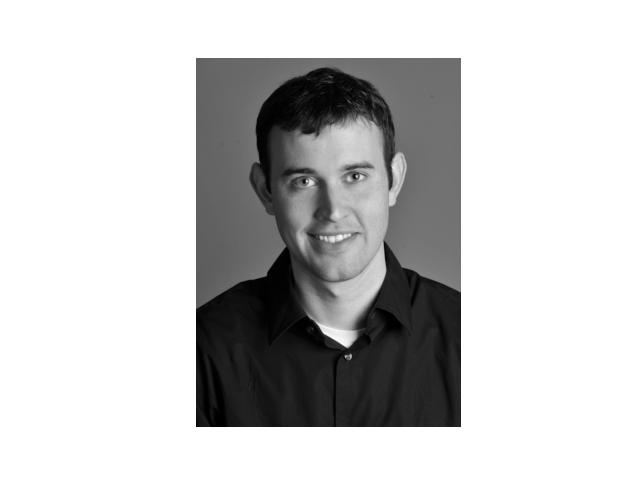

In [8]:
pts_im2 = utils.prompt_eye_selection(im2)
# pts_im2 = np.array([[299,343], [439,331]]) # uncomment if entering [x, y] pts manually
# plt.plot(pts_im2[:,0], pts_im2[:,1], 'r-+')
# print(pts_im2)

In [9]:
print(pts_im1)

[[609.2143  286.35715]
 [757.7857  366.35715]]


In [10]:
im1, im2 = utils.align_images(im1_file, im2_file,pts_im1,pts_im2,save_images=False)


In [11]:
# convert to grayscale
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY) / 255.0
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY) / 255.0

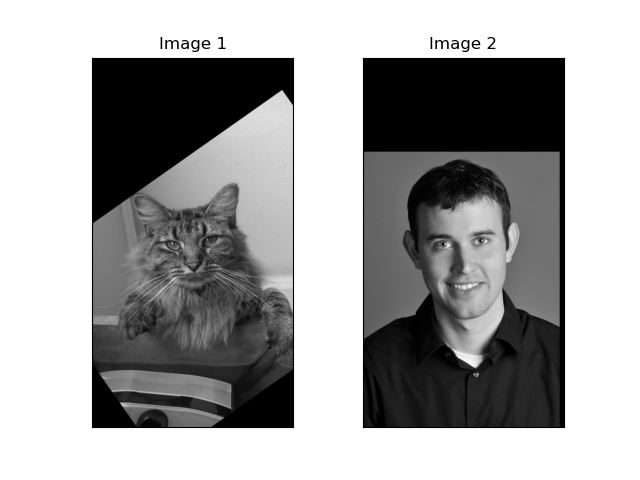

In [12]:
#Images sanity check
fig, axes = plt.subplots(1, 2)
axes[0].imshow(im1,cmap='gray')
axes[0].set_title('Image 1'), axes[0].set_xticks([]), axes[0].set_yticks([])
axes[1].imshow(im2,cmap='gray')
axes[1].set_title('Image 2'), axes[1].set_xticks([]), axes[1].set_yticks([]);

In [13]:
def fft_domain_filter_image(im, fil):
    H, W = im.shape
    padding = fil.shape[0] // 2
    fftsize = 2048
    ffted_im = np.fft.fft2(im, (fftsize, fftsize))
    ffted_fil = np.fft.fft2(fil, (fftsize, fftsize))
    filtered_im_in_fft_domain = ffted_im * ffted_fil
    filtered_im_wt_padding = np.fft.ifft2(filtered_im_in_fft_domain)
    filtered_im = filtered_im_wt_padding[padding:padding + H, padding:padding + W]
    filtered_im = np.real(filtered_im)
    return filtered_im

def hybridImage(im1, im2, sigma_low, sigma_high):
    '''
    Inputs:
        im1:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        im2:    RGB (height x width x 3) or a grayscale (height x width) image
                as a numpy array.
        sigma_low: standard deviation for the low-pass filter
        sigma_high: standard deviation for the high-pass filter
        
    Output:
        Return the combination of both images, one filtered with a low-pass filter
        and the other with a high-pass filter.
    '''  

    # your code goes here  
    ksize_low = int(np.ceil(sigma_low)*6+1)
    gauss_fil_low = cv2.getGaussianKernel(ksize_low, sigma_low)
    gauss_fil_low = gauss_fil_low*np.transpose(gauss_fil_low)

    ksize_high = int(np.ceil(sigma_high)*6+1)
    gauss_fil_hi = cv2.getGaussianKernel(ksize_high, sigma_high)
    gauss_fil_hi = gauss_fil_hi*np.transpose(gauss_fil_hi)

    impulse = np.zeros((ksize_high, ksize_high))
    impulse[ksize_high // 2, ksize_high // 2] = 1
    fil_hi = impulse - gauss_fil_hi

    filtered_im1_low = fft_domain_filter_image(im1, gauss_fil_low)
    filtered_im2_hi = fft_domain_filter_image(im2, fil_hi)

    im_res = np.fft.ifft2(np.fft.fft2(filtered_im1_low) + np.fft.fft2(filtered_im2_hi))

    return np.real(im_res)




In [20]:
sigma_low = 20 # choose parameters that work for your images
sigma_high = 20

im_hybrid = hybridImage(im2, im1, sigma_low, sigma_high)


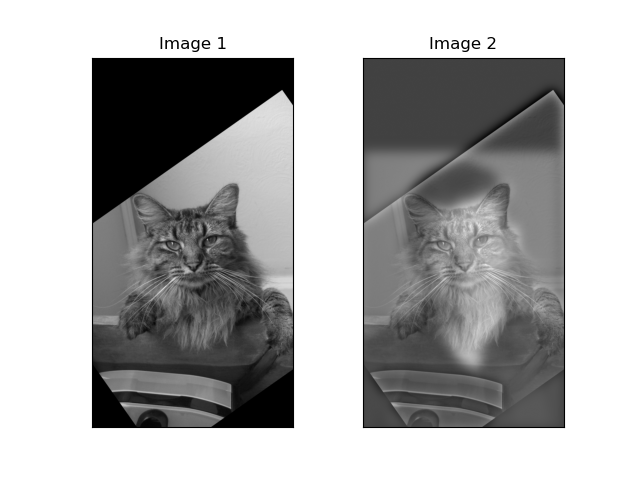

In [21]:
plt.imshow(im_hybrid,cmap='gray')
plt.show()

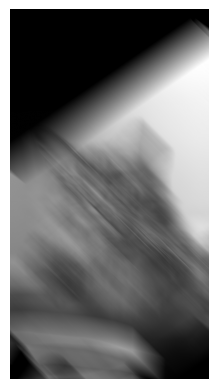

In [ ]:
# Optional: Select top left corner and bottom right corner to crop image
# the function returns dictionary of 
# {
#   'cropped_image': np.ndarray of shape H x W
#   'crop_bound': np.ndarray of shape 2x2
# }
cropped_object = utils.interactive_crop(im_hybrid)

### Part II: Image Enhancement

##### Two out of three types of image enhancement are required.  Choose a good image to showcase each type and implement a method.  This code doesn't rely on the hybrid image part.

#### Contrast enhancement

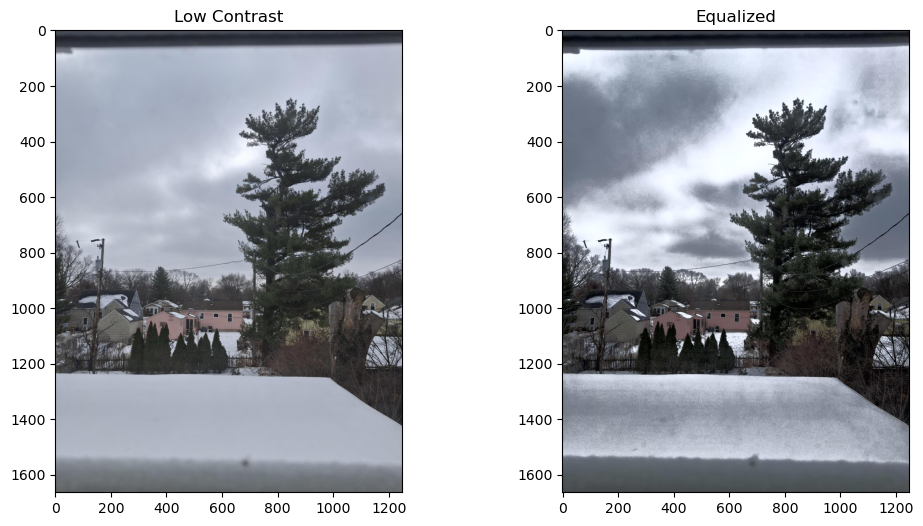

True

In [ ]:
low_contrast_im = cv2.imread('Pic1_LowContrast.jpg')

img_yuv = cv2.cvtColor(low_contrast_im, cv2.COLOR_BGR2YUV) # Method: Converting to YUV to extract the Luminance Y factor from the pixels 
# (Luminance controls the "contrastness" of the iamge)

img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0]) # Method: Histogram Equalizer applied only on Luminance to equalize the contrast

img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)

# Display results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1), plt.imshow(cv2.cvtColor(low_contrast_im, cv2.COLOR_BGR2RGB)), plt.title('Low Contrast')
plt.subplot(1, 2, 2), plt.imshow(cv2.cvtColor(img_output, cv2.COLOR_BGR2RGB)), plt.title('Equalized')
plt.show()

# Save the result
cv2.imwrite('Pic1_Fixed.jpg', img_output)

#### Color enhancement 

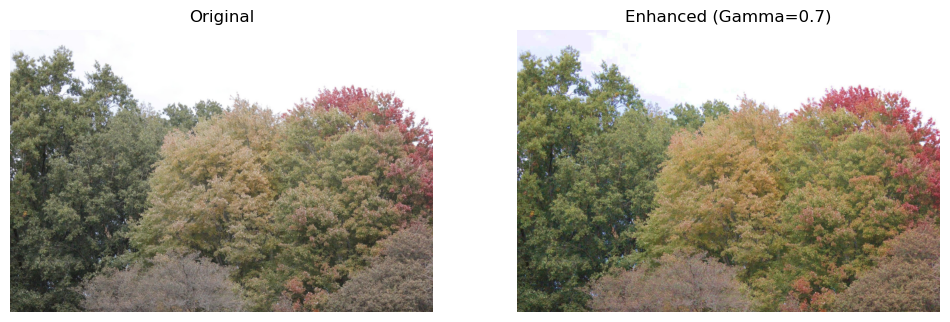

In [ ]:
unsaturated_im = cv2.imread('./Pic2_Unsaturated.jpg')
unsaturated_im_float = unsaturated_im.astype(np.float32) / 255.0

# Convert to HSV color space
hsv = cv2.cvtColor(unsaturated_im_float, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

# Apply Gamma correction: S_enhanced = S_old ^ gamma and V_enhanced = V_old ^ v_gamma
gamma = 0.7
s_enhanced = np.power(s, gamma)

v_gamma = 0.9 # Lower gamma = brighter image
v_enhanced = np.power(v, v_gamma)

hsv_enhanced = cv2.merge([h, s_enhanced, v_enhanced])
enhanced_bgr = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)
enhanced_img = np.clip(enhanced_bgr * 255.0, 0, 255).astype(np.uint8)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Original")
plt.imshow(cv2.cvtColor(unsaturated_im, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title(f"Enhanced (Gamma={gamma})")
plt.imshow(cv2.cvtColor(enhanced_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()


#### Color shift